# <img src="https://img.icons8.com/dusk/64/000000/artificial-intelligence.png" style="height:50px;display:inline"> EE 046202 - Technion - Unsupervised Learning & Data Analysis
---

## Computer Assignment 2 - Variational Autoencoders & Clustering
---

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* Variational Autoencoders (VAEs)
    * $\beta$-VAE
    * Conditional VAE (CVAE)
    * BONUS: Generating Pokemons
* Clustering with GNNs

#### Use as many cells as you need
#### אפשר גם לכתוב בעברית, אבל עדיף באנגלית

* Code Tasks are denoted with: <img src="https://img.icons8.com/color/48/null/code.png">
* Questions (which you need to answer in a Markdown cell) are denoted with: <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png">

### <img src="https://img.icons8.com/bubbles/50/null/information.png" style="height:50px;display:inline"> Students Information
---
* Fill in

|Name     |Campus Email| ID  |
|---------|--------------------------------|----------|
|Student 1| student_1@campus.technion.ac.il| 123456789|
|Student 2| student_2@campus.technion.ac.il| 987654321|


### <img src="https://img.icons8.com/bubbles/50/null/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
* Maximal garde: **100** (even with the bonus, the grade will not be above 100).
    * Example: if you got 5 points bonus, but you were right in all sections, your grade will still be 100 (and not 105).
    * Example: if you got 5 points bonus, and 6 points were deducted for wrong answers, your grade will be 99.
* Submission only in **pairs**. 
    * Please make sure you have registered your group in Moodle (there is a group creation component on the Moodle where you need to create your group and assign members).
* **BONUS**:
    * 5 points - completing the Pokemon task with *fully-connected* layers (black & white version)
    * 10 points - completing the Pokemon task with *convolutional* layers (RGB version)
* **No handwritten submissions.** You can choose whether to answer in a Markdown cell in this notebook or attach a PDF with your answers.
* <a style='color:red'> SAVE THE NOTEBOOKS WITH THE OUTPUT, CODE CELLS THAT WERE NOT RUN WILL NOT GET ANY POINTS! </a>
* What you have to submit:
    * Submit a `.zip` file with the name `ee046202_wet2_id1_id2.zip` with content:
        * `ee046202_wet2_id1_id2.ipynb` - the code tasks
        * `ee046202_wet2_id1_id2.pdf` - answers to questions. If you solved everything in the notebook, print the notebook as pdf.
    * No other file-types (`.py`, `.docx`...) will be accepted.
* Submission on the course website (Moodle).
* **Latex in Colab** - in some cases, Latex equations may no be rendered. To avoid this, make sure to not use *bullets* in your answers ("* some text here with Latex equations" -> "some text here with Latex equations").

### <img src="https://img.icons8.com/clouds/96/null/keyboard.png" style="height:50px;display:inline"> Keyboard Shortcuts
---
* Run current cell: **Ctrl + Enter**
* Run current cell and move to the next: **Shift + Enter**
* Show lines in a code cell: **Esc + L**
* View function documentation: **Shift + Tab** inside the parenthesis or `help(name_of_module)`
* New cell below: **Esc + B**
* Delete cell: **Esc + D, D** (two D's)

### <img src="https://img.icons8.com/cute-clipart/64/null/info.png" style="height:50px;display:inline"> Tip
---
If you find it more convenient, you can copy the section to a new cell, and answer the question or rite the code just right below it. For example:

#### Question 0
1. What is the best course in the Technion?
2. Why does no one pick Bulbasaur as first pokemon?
3. Why is there no superhero named Catman?

#### Answers - Q0

#### Q0 - Section 1
* Q: What is the best course in the Technion?

In [ ]:
print("ANAM!")

#### Q0 - Section 2
* Q: Why does no one pick Bulbasaur as first pokemon?

It is really a riddle....

#### Q0 - Section 3
* Q: Why is there no superhero named Catman?

I got nothing.

### <img src="https://img.icons8.com/cotton/64/null/grand-master-key.png" style="height:50px;display:inline"> Part 1 - Variational Autoencoders - Prologue
---
In this section of the exercise we will analyze the VAE and introduce an enhacement called $\beta$-VAE and also a variation of VAE that allows us some control over the latent space using conditional probability - Conditional Variational Autoencoder.

For this part, you are provided the original implementation of the VAE from the tutorial. You will have to modify it throughout the tasks (yes, you can copy-paste from the original implementation).
* **Note** - for better results you should tune the model!
    * You can add layers / hidden units / different activations (ReLU, TanH, LeakyReLU, Sigmoid...)
    * You can choose a different optimizer than Adam (SGD, RMSProp...), tune the learning rate...
    * You can change the reconstruction loss (BCE, MSE, L1...)
    * Other hyper-parameters like the batch-size, number of epochs and etc...

We recommend running this part on Google Colab or on a GPU (if you have an access to one). Note that running on a GPU will lead to about x2 speedup in training. 

In [2]:
# imports for the exrcise - part 1
# you can add more if you wish (but it is not really needed)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torchvision

In [3]:
# the original implementation from the tutorial - leave untouched (for your own sake), copy-paste what you need to another cell

# reparametrization trick
def reparameterize(mu, logvar, device=torch.device("cpu")):
    """
    This function applies the reparameterization trick:
    z = mu(X) + sigma(X)^0.5 * epsilon, where epsilon ~ N(0,I)
    :param mu: mean of x
    :param logvar: log variance of x
    :param device: device to perform calculations on
    :return z: the sampled latent variable
    """
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std).to(device)
    return mu + eps * std


# encoder - Q(z|X)
class VaeEncoder(torch.nn.Module):
    """
       This class builds the encoder for the VAE
       :param x_dim: input dimensions
       :param hidden_size: hidden layer size
       :param z_dim: latent dimensions
       :param device: cpu or gpu
       """

    def __init__(self, x_dim=28*28, hidden_size=256, z_dim=10, device=torch.device("cpu")):
        super(VaeEncoder, self).__init__()
        self.x_dim = x_dim
        self.hidden_size = hidden_size
        self.z_dim = z_dim
        self.device = device
        
        self.features = nn.Sequential(nn.Linear(x_dim, self.hidden_size),
                                      nn.ReLU())
        
        self.fc1 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  # fully-connected to output mu
        self.fc2 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  # fully-connected to output logvar


    def bottleneck(self, h):
        """
        This function takes features from the encoder and outputs mu, log-var and a latent space vector z
        :param h: features from the encoder
        :return: z, mu, log-variance
        """
        mu, logvar = self.fc1(h), self.fc2(h)
        # use the reparametrization trick as torch.normal(mu, logvar.exp()) is not differentiable
        z = reparameterize(mu, logvar, device=self.device)
        return z, mu, logvar

    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        z, mu, logvar = VaeEncoder(X)
        """
        h = self.features(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    
class VaeDecoder(torch.nn.Module):
    """
       This class builds the decoder for the VAE
       :param x_dim: input dimensions
       :param hidden_size: hidden layer size
       :param z_dim: latent dimensions
       """

    def __init__(self, x_dim=28*28, hidden_size=256, z_dim=10):
        super(VaeDecoder, self).__init__()
        self.x_dim = x_dim
        self.hidden_size = hidden_size
        self.z_dim = z_dim
        
        self.decoder = nn.Sequential(nn.Linear(self.z_dim, self.hidden_size),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_size, self.x_dim),
                                     nn.Sigmoid())
        # why we use sigmoid? becaue the pixel values of images are in [0,1] and sigmoid(x) does just that!
        # if you don't work with images, you don't have to use that.


    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        x_reconstruction = VaeDecoder(z)
        """
        x = self.decoder(x)
        return x
    

class Vae(torch.nn.Module):
    def __init__(self, x_dim=28*28, z_dim=10, hidden_size=256, device=torch.device("cpu")):
        super(Vae, self).__init__()
        self.device = device
        self.z_dim = z_dim

        self.encoder = VaeEncoder(x_dim, hidden_size, z_dim=z_dim, device=device)
        self.decoder = VaeDecoder(x_dim, hidden_size, z_dim=z_dim)

    def encode(self, x):
        z, mu, logvar = self.encoder(x)
        return z, mu, logvar

    def decode(self, z):
        x = self.decoder(z)
        return x

    def sample(self, num_samples=1):
        """
        This functions generates new data by sampling random variables and decoding them.
        Vae.sample() actually generatess new data!
        Sample z ~ N(0,1)
        """
        z = torch.randn(num_samples, self.z_dim).to(self.device)
        return self.decode(z)

    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        return x_recon, mu, logvar, z = Vae(X)
        """
        z, mu, logvar = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z
    

def loss_function(recon_x, x, mu, logvar, loss_type='bce'):
    """
    This function calculates the loss of the VAE.
    loss = reconstruction_loss - 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param recon_x: the reconstruction from the decoder
    :param x: the original input
    :param mu: the mean given X, from the encoder
    :param logvar: the log-variance given X, from the encoder
    :param loss_type: type of loss function - 'mse', 'l1', 'bce'
    :return: VAE loss
    """
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='sum')
    elif loss_type == 'l1':
        recon_error = F.l1_loss(recon_x, x, reduction='sum')
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction='sum')
    else:
        raise NotImplementedError

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_error + kl) / x.size(0)



### <img src="https://img.icons8.com/color/48/null/code.png" style="height:50px;display:inline"> Task 1 - $\beta$-VAE
---
In the standard VAE, an isotropic Gaussian ($p(z) \sim \mathcal{N}(0, I)$) is typically assumed as the prior distribution for z. Note that under this distribution the components of z are independent (e.g. disentangled - a disentangled representation can be defined as one where single latent units are sensitive to changes in single generative factors, while being relatively invariant to changes in other factors) which is exactly the property we would like our approximate posterior distribution (e.g. $q(z|x)$) to have. Thus, to encourage independence we increase the KL-divergence term in the ELBO by a factor of $\beta$: $$ \mathcal{L}_{\beta-VAE} = -\mathbb{E}_{q_{\phi(z|x)}}[p_{\theta}(x|z)] + \beta \cdot D_{KL}[q_{\theta}(z|x) || p(z)]  $$
   * Training is performed exactly the same as for the standard VAE.
   * When $\beta=1$, it is same as VAE.
   * When $\beta>1$, it applies a stronger constraint on the latent bottleneck and limits the representation capacity of $z$. 
       * For some conditionally independent generative factors, keeping them disentangled is the most efficient representation.
   * When $0<\beta<1$, it can be interpreted as optimizing an approximate log marginal likelihood bound under an alternative prior, regularized to prevent degeneracy (of the KL-divergence).
   
The tasks:
1. Modify the loss function to support $\beta$-VAE. The function should return the reconstruction loss, the kl-divergence (**without the multiplication by $\beta$**) and the total loss.
    * The signature of the function should be: `beta_loss_function(recon_x, x, mu, logvar, loss_type='bce', beta=1)`
    * The reconstruction loss, the kl-divergence and and the total loss should be normalzied by the batch size.
    * The returned reconstruction loss and kl-divergence should be converted to numpy: `kl_d.data.cpu().numpy()` (but only them, not the total loss)
2. Load the MNIST dataset, as in the tutorial, and create a train loader.
3. For $\beta=[0.05, 0.5, 1, 5]$, train a $\beta$-VAE for 50 epochs and keep track of:
    * The average reconstruction loss in each epoch
    * The average KL-divergence in each epoch
    * A checkpoint of the network in the format: `beta_(value of beta)_vae_50_epochs.pth` (there is an example in the tutorial)
        * DO NOT SUBMIT THE CHECKPOINTS, THEY ARE FOR YOU TO USE.
    * This may take a while, so go grab a coffee in the meantime :)
4. For $\beta=[0.05, 0.5, 1, 5]$, plot the KL-divergence and reconstruction error vs. epochs.
5. For $\beta=[0.05, 0.5, 1, 5]$, generate 5 samples from the VAE and plot them (`imshow`...). Run this a couple of times to get an impression of the samples for each $\beta$.


* Notes:
    * Be organized - separate to different code cells if it keeps you organized.
    * Make sure to properly define the hyper-parameters (see tutorial), and define the `device` automatically. Don't forget to send all the models and tensors to the device. We will run your code on a GPU.
    * If you are not satisfied with the results, and you have time, you can try and increase the number of epochs to 100, and see what happens.

**Answers:**

1) Beta loss function

In [4]:
def beta_loss_function(recon_x, x, mu, logvar, loss_type='bce',beta=1):
    """
    This function calculates the loss of the VAE.
    loss = reconstruction_loss - 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param recon_x: the reconstruction from the decoder
    :param x: the original input
    :param mu: the mean given X, from the encoder
    :param logvar: the log-variance given X, from the encoder
    :param loss_type: type of loss function - 'mse', 'l1', 'bce'
    :return: VAE loss
    """
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='sum')
    elif loss_type == 'l1':
        recon_error = F.l1_loss(recon_x, x, reduction='sum')
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction='sum')
    else:
        raise NotImplementedError

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_error.data.cpu().numpy() / x.size(0), kl.data.cpu().numpy() / x.size(0) ,(recon_error + beta*kl) / x.size(0) 


2) download data set and show some examples

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



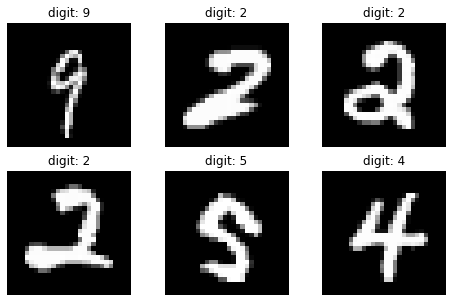

In [5]:
# your code here - you can use as many cells as you need
transform = torchvision.transforms.ToTensor()
train_data = torchvision.datasets.MNIST('./datasets/', train=True, transform=transform,
 target_transform=None, download=True)
test_data = torchvision.datasets.MNIST('./datasets/', train=False, transform=transform,
 target_transform=None, download=True)
sample_dataloader = DataLoader(train_data, batch_size=6, shuffle=True, drop_last=True)
fig = plt.figure(figsize=(8 ,5))
samples, labels = next(iter(sample_dataloader))
for i in range(samples.size(0)):
 ax = fig.add_subplot(2, 3, i + 1)
 ax.imshow(samples[i][0, :, :].data.cpu().numpy(), cmap='gray')
 title = "digit: " + str(labels[i].data.cpu().item())
 ax.set_title(title)
 ax.set_axis_off()


(3) running for Beta 

In [20]:
# define hyper-parameters
BETA =  [0.05,0.5,1,5]
BATCH_SIZE =  128 # usually 32/64/128/256 was 128
LEARNING_RATE = 1e-3 # for the gradient optimizer
NUM_EPOCHS = 100 # how many epochs to run? was 50


running calculations on:  cuda:0
epoch: 0 training loss: 152.24202 epoch time: 6.360 sec
epoch: 1 training loss: 105.64769 epoch time: 7.555 sec
epoch: 2 training loss: 100.07472 epoch time: 6.931 sec
epoch: 3 training loss: 97.01712 epoch time: 6.255 sec
epoch: 4 training loss: 94.91761 epoch time: 6.653 sec
epoch: 5 training loss: 93.40059 epoch time: 7.394 sec
epoch: 6 training loss: 92.29216 epoch time: 6.702 sec
epoch: 7 training loss: 91.36189 epoch time: 6.816 sec
epoch: 8 training loss: 90.62546 epoch time: 6.909 sec
epoch: 9 training loss: 89.97688 epoch time: 6.765 sec
epoch: 10 training loss: 89.42500 epoch time: 6.824 sec
epoch: 11 training loss: 88.94124 epoch time: 6.691 sec
epoch: 12 training loss: 88.51372 epoch time: 6.708 sec
epoch: 13 training loss: 88.14817 epoch time: 6.880 sec
epoch: 14 training loss: 87.80296 epoch time: 6.740 sec
epoch: 15 training loss: 87.47825 epoch time: 6.861 sec
epoch: 16 training loss: 87.17458 epoch time: 6.891 sec
epoch: 17 training los

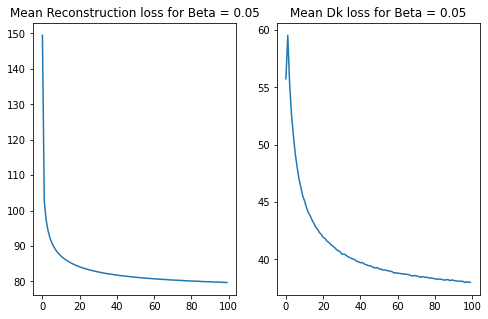

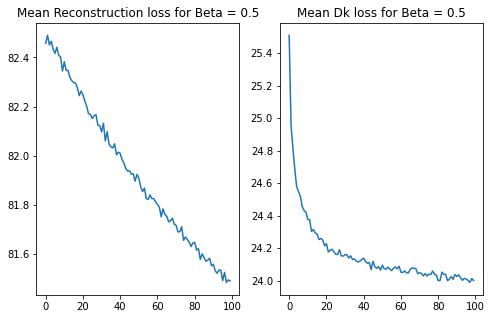

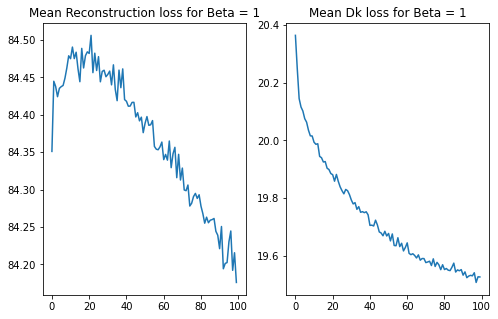

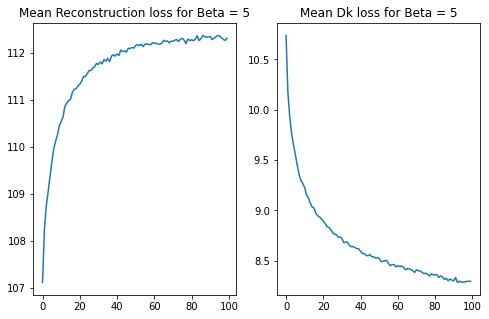

In [21]:
HIDDEN_SIZE = 256 # size of the hidden layers in the networks
X_DIM = 28 * 28 # size of the input dimensio
Z_DIM = 10 # size of the latent dimension
# training
# check if there is gpu avilable, if there is, use it
if torch.cuda.is_available():
 torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print("running calculations on: ", device)
# load the data
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# create our model and send it to the device (cpu/gpu)
vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
# optimizer
vae_optim = torch.optim.Adam(params=vae.parameters(), lr=LEARNING_RATE)

# here we go
for beta in BETA:
  # save the losses from each epoch, we might want to plot it later
  train_losses = []
  recon_mean = []
  kl_mean = []
  for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    batch_losses = []
    recon_loss = []
    kl_loss = []
    for batch_i, batch in enumerate(dataloader):
      # forward pass
      x = batch[0].to(device).view(-1, X_DIM) # just the images
      x_recon, mu, logvar, z = vae(x)
      # calculate the loss
      recon,kl,loss = beta_loss_function(x_recon, x, mu, logvar, loss_type='bce',beta=beta)
      # optimization (same 3 steps everytime)
      vae_optim.zero_grad()
      loss.backward()
      vae_optim.step()
      # save loss
      batch_losses.append(loss.data.cpu().item())
      recon_loss.append(recon)
      kl_loss.append(kl)
    
    train_losses.append(np.mean(batch_losses))
    print("epoch: {} training loss: {:.5f} epoch time: {:.3f} sec".format(epoch, train_losses[-1],
    time.time() - epoch_start_time))
    recon_mean.append(np.array(recon_loss).mean())
    kl_mean.append(np.array(kl_loss).mean())
  # save
  fname = "beta_("+str(beta)+" )_vae_50_epochs.pth"
  torch.save(vae.state_dict(), fname)
  print("saved checkpoint @", fname)
  fig = plt.figure(figsize=(8 ,5))
  ax = fig.add_subplot(1, 2, 1)
  ax.set_title("Mean Reconstruction loss for Beta = " + str(beta))
  ax.plot(recon_mean)
  bx =  fig.add_subplot(1, 2, 2)
  bx.set_title("Mean Dk loss for Beta = " + str(beta))
  bx.plot(kl_mean)

### <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png" style="height:50px;display:inline"> Question 1 - $\beta$-VAE
---
We will now analyze the results. Answer the following questions:
1. Explain intuitively the loss function of $\beta$-VAE. In your answer, explain the trade-off between the reconstruction loss and the KL-divergence and how it is affected by the $\beta$ parameter. Hint: think about regularization as you learned in the ML course (for example, in linear regression).
2. What is the main trend in the KL and reconstruction loss vs. epochs? In your answer, you should compare between the $\beta$'s.
3. For what values of $\beta$ you would expect better reconstruction (why would we want better reconstruction?) and for what values you would expect higher-quality samples? In your answer, refer to the blurriness in the samples you plotted.
4. Run the cell where you plot the samples (if you separated the cells for each $\beta$, then run all of them) a couple of times (just hit Ctrl + Enter). For which value of $\beta$ there is more *diversity* in the samples? (i.e., if out of 6 samples you get four 9's, it is not actually diverse).

### <img src="https://img.icons8.com/color/48/null/code.png" style="height:50px;display:inline"> Task 2 - Conditional VAE (CVAE)
---
Conditional Variational Autoencoder (CVAE) is an extension of Variational Autoencoder (VAE).
However, as you may have noticed, we have no control on the data generation process of the VAE. That is, for example, on MNIST, we could not control the latent space, and when we sampled, we would not know what digit would be generated. This could be problematic if we want to generate some specific data. As an example, suppose we want to convert a unicode character to handwriting. In vanilla VAE, there is no way to generate the handwriting based on the character that the user inputted. Concretely, suppose the user inputted character ‘2’, how do we generate handwriting image that is a character ‘2’? We couldn’t.

Hence, CVAE was developed. Whereas VAE essentially models latent variables and data directly, CVAE models latent variables and data, both conditioned to some random variables.
Recall, on VAE, the objective is:
$$\log P(X) -  D_{KL}[Q(z|X) || P(z|X)]  =  \mathbb{E}_{Q(z|X)}[\log P(X|z)] -D_{KL}[Q(z|X)|| P(z)]  $$
that is, we want to optimize the log likelihood of our data $P(X)$ under some “encoding” error. The original VAE model has two parts: the encoder $Q(x|Z)$ and the decoder $P(X|z)$.

If we focus on the encoder, it models the latent variable $z$ directly based on $X$, and it doesn't care about the different types of $X$ (e.g., it doesn't care if it is 1 or an 8). But wait, this was all the idea of **unsupervised learning**, we have no access to labels. Well, in this case, we have some information (thus, CVAE is sometimes referred to as **semi-supervised** learning model).

Similarly, in the decoder part, it only models $X$ directly based on the latent variable $z$. So, how do we tell the VAE what we want to generate? We can condition encoder and decoder to another things, let's denote them with $c$ (for "condition").

* The encoder is now conditioned on 2 variables- $X, c$: $Q(z|X,c)$ and the decoder in now conditioned on- $z$, $c$: $P(X|z,c)$
* Hence, our variational lower bound objective is now in this following form: $$ \log P(X|c) -  D_{KL}[Q(z|X,c) || P(z|X,c)]  =  \mathbb{E}_{Q(z|X,c)}[\log P(X|z,c)] -D_{KL}[Q(z|X,c)|| P(z|c)] $$ (we just conditioned all of the distributions with a variable $c$)
* So what is different? Almost nothing! We still model $P(z|c) \sim \mathcal{N}(0,I)$, and the rest are modeled by the neural network.
* But how is it done in practice? Simple! **Concatenation**: instead of encoding $X$, we encoded $[X,c]$, that is, we concatenate them. Same for the decoder: we take the latent variable $z$ and concatenate with $c$ and then the input of the decoder is $[z,c]$.
* In PyTorch, we concatenate with `x = torch.cat([x, x_cond], dim=1)` (the 0 dimension is the batch dimension).

The tasks:
* Load the Fashion-MNIST dataset, as in the tuorial, and create a train loader. Note that you get both the images and their **labels**.
* The labels are the classes (0-9). In order to use them in the network we need to convert them to one-hot vectors (0 -> [1,0,0,0,0,0,0,0,0,0], 1 -> [0,1,0,0,0,0,0,0,0,0] ...). The length of the one hot vector in as the number of classes. You are given a function that converts ints to one-hot vectors, use it on the labels, before you perform the concatenation.
* Modify the VAE architecture to support conditionals.
    * Copy-paste the skeleton (the original VAE, from the begining of the tutorial), and just modify the current functions. Note that there **are very few** changes needed.
    * Here are some tips, but feel free to implement as you wish, as long as it works:
        * In Python, you can let a function input be `None`, and then if the user inputs something that is not `None`, the function would act different. Here is an example: `def encode(x, x_cond=None): if x_cond is not None: ...`
        * Here are the parts that we recommend you change:
            * In the Vae module:
                * `def __init__(self, x_dim=28*28, z_dim=10, hidden_size=256, device=torch.device("cpu"), cond_dim=None)`
                * `def sample(self, num_samples=1, x_cond=None)`
                * `def forward(self, x, x_cond=None)`
            * Note that these are the minimal changes that can be done to implement VAE that supports CVAE. No need to modify VaeEncoder and VaeDecoder when we are using fully-connected layers. However, if we were to use convolutional layers, we would have to change also the encoder and decoder since convolutional layers work on images, and only after the images features from the convolutional layers have been extracted, we would concatenate the the condional $c$ (just before the fully-connected layers that output $\mu, \sigma$.
* Train CVAE on the Fashion-MNIST dataset (100 epochs, at least). Use $\beta$-VAE loss function (it shouldn't have changed from the regular VAE. Save a checkpoint of the network in the format: `fmnist_beta_(value of beta)_cvae_(number of epochs)_epochs.pth`. The rest of the hyper-parameters are up to you.
* Plot $n_{samples}=6$ from the CVAE for 6 classes of your choosing.
* **Tip**: this may take a while, so if everything seems to work, let it run on Google Colab and go grab another coffee.

In [ ]:
def labels_to_one_hots(batch, num_classes=10):
    """
    Converts batch of integes numbers to one-hot vector given the vector length
    :param batch: batch of values to convert
    :param num_classes: length of the vector
    :return: one_hot_batch
    """
    one_hot_batch = torch.zeros(batch.size(0), num_classes).to(batch.device)
    for i in range(batch.size(0)):
        one_hot_batch[i, int(batch[i].data.cpu().item())] = 1
    return one_hot_batch

In [ ]:
# your code here - you can use as many cells as you need

### <img src="https://img.icons8.com/bubbles/48/null/ask-question.png" style="height:50px;display:inline"> Question 2 - Conditional VAE
---
1. Can we perform interpolation of the latent space as we did in the tutorial? What is the meaning of doing **in-class** interpolation in the case of Fashion-MNIST? Explain.
2. Why did we convert the the classes number to one-hot vectors? Think of the other inputs to the networks and the values that the neurons accept. What is the risk of using just one number as the condition instead of a vector?
3. How is the quality of the samples? How can the quality be improved? In you answer, refer to the bluriness in the samples.

### <img src="https://img.icons8.com/color/48/null/code.png" style="height:50px;display:inline"> Task 2 - BONUS - Pokemon: Gotta Generate 'Em All!
---
This is a **non-mandatory**, more challenging task. Come back here only if you are done with the rest of the exercise and want to take on a challenge.

* Note - you should pick one of the following:
    * Fully-connected - work with grayscale images (5 points)
    * Convolutional - work with RGB images (10 points)
* No matter what type of model you chose, you need to answer the bonus questions that follow the code.

In this task we are going to (try) generate new pokemons! Our dataset includes ~900 pokemons. Each sample is a 60x60 image and the type of the pokemon (18 classes). The type is already in one-hot form. If you have access to a GPU, we recommend trying the convolutional version of this task.

Let's look at the data, for the **fully-connected** version.

In [ ]:
from pokemon_dataset import PokemonDataset
poke_data = PokemonDataset(root='./data/pokemon', rgb=False)
sample_dataloader = DataLoader(poke_data, batch_size=6, shuffle=True, drop_last=True)

In [ ]:
fig = plt.figure(figsize=(10 ,5))
samples, labels = next(iter(sample_dataloader))
for i in range(samples.size(0)):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(samples[i][0].data.cpu().numpy(), cmap="gray")
    ax.set_axis_off()
    
print("can you name these pokemons?")

In [ ]:
# let's look at the types encoding
poke_data.type_to_one_hot

**The task**: Implement CVAE for the pokemon dataset, it should not be different than the one you implemented for Fashion-MNIST. The task is to define the model and tune the hyper-parameters. 
Note that due to being a really small dataset (only 900 examples!) you will need a really large number of epochs to get something. We don't expect to see actual pokemons, but we want to see the that the networks learned something. You will also need a larger latent space dimension, as pokemons are more complex than cloths.

* If you have taken the **Computer Vision** course - you should add **data augementations** to the images, to create a more diverse dataset. Recommended augmentations: `RandomHorizontalFlip`, `ColorJitter`, random horizontal translation (up to 5 pixels).



* Train CVAE on the pokemon dataset. Save a checkpoint once you are done: `pokemon_beta_(value of beta)_vae_(num epochs)_epochs.pth`.
* Plot samples for at least 6 types of your choosing (try to find the better ones).
* Plot reconstructions for at least 6 types of your choosing.

In [ ]:
# your code here - you can use as many cells as you need

### Have access to a GPU and feel adventurous (CNN version)?
* If you have completed the fully-connected verion, you can just skip to the bonus questions.

If you feel creative and want to work with CNNs, we are giving you the VaeCnnEncoder and VaeCnnDecoder architectures, and all you have to do is implement the Vae class using these, and run the VAE with RGB images.
Let's look at the data.

In [ ]:
from pokemon_dataset import PokemonDataset
poke_data = PokemonDataset(root='./data/pokemon', rgb=True)
sample_dataloader = DataLoader(poke_data, batch_size=6, shuffle=True, drop_last=True)

fig = plt.figure(figsize=(10 ,5))
samples, labels = next(iter(sample_dataloader))
for i in range(samples.size(0)):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(samples[i].permute(1, 2, 0).data.cpu().numpy())  # permute to (Height, Width, Channels)
    ax.set_axis_off()
    
print("can you name these pokemons?")

### Your Turn
* Impelement the convolutional CVAE and train it. Save a checkpoint `"pokemon_cnn_beta_(value of beta)_vae_(num epochs)_epochs.pth"`
* Plot samples for at least 6 types of your choosing (try to find the better ones).
* Plot reconstructions for at least 6 types of your choosing.


* Note that the call to the loss function in the training loop is in the form: `loss = loss_function(x_recon, x.permute(0, 2, 3, 1), mu, logvar, loss_type='bce', beta=beta)`.
    * This is because `x_recon` is in the shape (batch_size, H, W, C) and `x` is (batch_size, C, H, W).
* Use a lower leraning rate (start with `1e-4`).

* Components:
    * Conv2D - `nn.Conv2d(in_channels, out_channels, kernel_size, stride)`
    * Deconv2d - `nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding)`
    * Batch Normalization 1D - `nn.BatchNorm1d(num_features, affine=True)`
    * Batch Normalization 2D - `nn.BatchNorm2d(num_features, affine=True)`
    * Calculate the convolutional output size with `_get_conv_out(self, shape)` as in tutorial 8.
    * FC/Linear - `nn.Linear(in, out)`

#### Encoder Architecture - `VaeCnnEncoder(torch.nn.Module)`
* Block 1:
    * Conv2d - `in_channels=3, out_channels=128, kernel_size=(3, 3), stride=(2, 2), padding=1`
    * Batch Normalization 2D - 128 features
    * ReLU (or any other activation you want)
* Block 2:
    * Conv2d - `in_channels=128, out_channels=64*4, kernel_size=(3, 3), stride=(2, 2), padding=1`
    * Batch Normalization 2D - $64*4$ features
    * ReLU (or any other activation you want)
* Block 3:
    * Conv2d - `in_channels=64*4, out_channels=64*8, kernel_size=(3, 3), stride=(2, 2), padding=1`
    * Batch Normalization 2D - $64*8$ features
    * ReLU (or any other activation you want)
* FC1 ($\mu$) - `nn.Linear(self._get_conv_out(x_shape) + self.cond_dim, self.z_dim)`
* FC1 ($\Sigma$) - `nn.Linear(self._get_conv_out(x_shape) + self.cond_dim, self.z_dim)`

#### Decoder Architecture - `VaeCnnDecoder(torch.nn.Module)`
* FC1 ($z$) - `nn.Linear(self.z_dim (+cond_dim), 64 * 4 * 4 * 4)`
* Batch Normalization 1D - $64*4*4*4$ features.
* Block 1:
    * Deconv2d - `in_channels=64 * 4, 64 * 2, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1`
    * Batch Normalization 2D - 128 features
    * ReLU (or any other activation you want)
* Block 2:
    * Deconv2d - `in_channels=128, 64, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1`
    * Batch Normalization 2D - 64 features
    * ReLU (or any other activation you want)
* Block 3:
    * Deconv2d - `in_channels=64, 64, kernel_size=(3, 3), stride=(2, 2), padding=2, output_padding=1`
    * Batch Normalization 2D - 64 features
    * ReLU (or any other activation you want)
* Deconv2d - `in_channels=64, 3, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1`
* Sigmoid



In [ ]:
# your code here

### <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png" style="height:50px;display:inline"> Bonus Question
---
1. What do you think about the results on the Pokemon dataset? Name at least 2 reasons for the VAE somewhat low performance on the Pokemon dataest.
2. Suggest ideas to improve the performance (at least 2).

### <img src="https://img.icons8.com/cotton/64/null/grand-master-key.png" style="height:50px;display:inline"> Part 2 - Clustering
---
In this task, we will use a graph convolutional network (GCN) to perform semi-supervised clustering.
Our goal is to use the graph structure to get accurate clusters for the data.

We will make use of the Pytorch geometric (PyG) library to provide us with implementations of GCNs and for importing datasets.
See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for installation instructions for your platform.

You may implement graph convolution layers by yourself if you prefer.

In [ ]:
# imports for the exrcise - part 2
# you can add more if you wish (but it is not really needed)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import warnings

# PyG imports
import torch
import torch.nn.functional as F
from torch_geometric.datasets.karate import KarateClub
from torch_geometric.nn import GCNConv

warnings.filterwarnings(category=UserWarning, action="ignore")

### <img src="https://img.icons8.com/color/48/null/code.png" style="height:50px;display:inline"> Task 3 - Implementing a GCN
---
* Implement a GCN module that has two graph convolution layers and a non-linearity.
    * Layer 1 should map the input features to a hidden representation
    * A ReLU activation should be run on the output of this first Graph convolution layer
    * Layer 2 should map the hidden representation to the outputs
    * You can use `GCNConv` from PyG for implementations of graph convolution layers, but do not use any models from PyG.
* Write your code in the blocks below such that the last block runs. 
    * The line `GCN(n_node_features, hidden_layer_size, num_clusters)` should run the initialization of the GCN.
    * The forward implementation should work with pyG data that has fields `data.x, data.edge_index` with signature `forward(self, data)`
* Print the resulting accuracy from running the test code

In [ ]:
# your code here - you can use as many cells as you need

In [ ]:
karate_dataset = KarateClub()
n_node_features = 34 #  from documentation
num_clusters = 4 #  from documentation
hidden_layer_size = 16 #  chosen by us
n_epochs = 20 #  chosen by us

gcn_model = GCN(n_node_features, hidden_layer_size, num_clusters)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = gcn_model.to(device)
data = karate_dataset.data.to(device)
print(data.x)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
train_mask = data.train_mask 
model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

# Classification accuracy for the graph data
model.eval()
test_mask = ~ train_mask
pred = model(data).argmax(dim=1)
correct = (pred[test_mask] == data.y[test_mask]).sum()
acc = int(correct) / int(test_mask.sum())
print(f'Accuracy: {acc:.4f}')

### <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png" style="height:50px;display:inline"> Question 3 - GCN basics
---
1. What are the features in the Karate Club dataset? How does this feature definition effect the GCN activation $AXW^{(1)}$?
2. For this GCN, how many neighbors is each node affected by? How did you determine this?

### <img src="https://img.icons8.com/color/48/null/code.png" style="height:50px;display:inline"> Task 4 - Clustering with a GCN
---
Now that we have trained a GCN with one labelled sample per class, we have a GCN that creates a good mapping of new points to clusters.
We note that combining GCNs and autoencoders can give us unsupervised clustering and seem to work well, but we will focus on the simpler setting where we have a few labels per class/cluster (in this case, one example).

1. Create a new GCN with `hidden_layer_size=4` and output dimension 2
2. Visualize the output of the untrained network as a two-dimensional embedding. Show different classes in different colors.
3. Train this GCN on the training data (use `data.train_mask`) of one example per class
    * Create a simple 2D embedding for class labels
        * for example, by mapping `labels = torch.vstack([2*(data.y % 2)-1, 2*((data.y>1).float())-1]).T`
    * Use MSE loss between the network output and the label embedding
    * You can use a `tanh` activation function instead of ReLU to get better results
    * Use the same optimizer as above: `torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)`
    * Run 300 training epochs
4. Visualize the output of the trained network on the entire dataset with the different classes in different colors.

In [ ]:
# your code here - you can use as many cells as you need

### <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png" style="height:50px;display:inline"> Question 4 - GCN for embedding
---
1. What is the effect of the semi-supervised training on the overall embedding? refer to the plots in your answer.
2. How does it make sense that training on only one point per class is enough to give a clustered embedding that separates classes well? Refer to the specific structure of GCN layers. Consider the differences between the embedding before and after training.

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
* Datasets from <a href="https://www.kaggle.com/">Kaggle</a> - https://www.kaggle.com/